In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

E:\anoconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\pytho

In [3]:
feanum=6
window=5
df2=pd.read_excel('database.xlsx') 
df1=df2.iloc[:,1:]
df1.tail()

,Open,High,Low,Close,Adj Close,Volume
2411,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [4]:
rate_origin=df1['Volume']

In [5]:
df=(df1-df1.min())/(df1.max()-df1.min())
df.tail()

,Open,High,Low,Close,Adj Close,Volume
2411,0.840012,0.727970,0.824703,0.721146,0.721146,0.248581
2412,0.850962,0.744851,0.838901,0.739584,0.739584,0.376663
2413,0.937237,0.824226,0.915692,0.817862,0.817862,0.615322
2414,0.948764,0.826981,0.937741,0.830633,0.830633,0.332310
2415,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#加载keras模块
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras
from keras.utils import np_utils
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [7]:
def load_data(stock, seq_len):#输入data表格
    amount_of_features = len(stock.columns)#有几列
    data = stock.as_matrix() #pd.DataFrame(stock) 讲表格转化为矩阵
    sequence_length = seq_len + 1#序列长度5+1
    result = []
    for index in range(len(data) - sequence_length):#循环170-5次
        result.append(data[index: index + sequence_length])#第i行到i+5行

    result = np.array(result)#得到161个样本，样本形式为6天*3特征
    row = round(0.9 * result.shape[0])#划分训练集测试集
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
#reshape成 5天*3特征
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [8]:
def build_model2(layers):
        d = 0.1
        model = Sequential()
        model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(32,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [9]:
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2169, 5, 6)
y_train (2169,)
X_test (241, 5, 6)
y_test (241,)


E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
model = build_model2([feanum,window,1])

W0315 09:29:11.792545 11040 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0315 09:29:12.399941 11040 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0315 09:29:12.630604 11040 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0315 09:29:13.829158 11040 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0315 09:29:13.837136 11040 deprec

In [11]:
history = LossHistory()

In [12]:
model.fit(
    X_train,
    y_train,
    batch_size=256,
    nb_epoch=50,
    validation_split=0.1,
    verbose=0,
    callbacks=[history])

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0315 09:29:14.847012 11040 deprecation.py:323] From E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0315 09:29:16.068904 11040 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



在测试集和验证集上的loss/acc下降情况


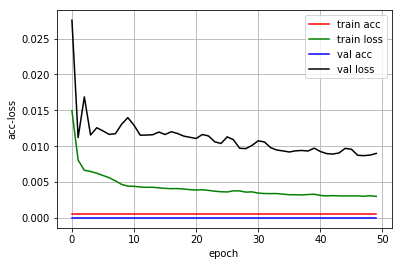

In [13]:
print('在测试集和验证集上的loss/acc下降情况')
history.loss_plot('epoch')

In [14]:
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train#[:,0]

Text(0.5,1,'Train Data')

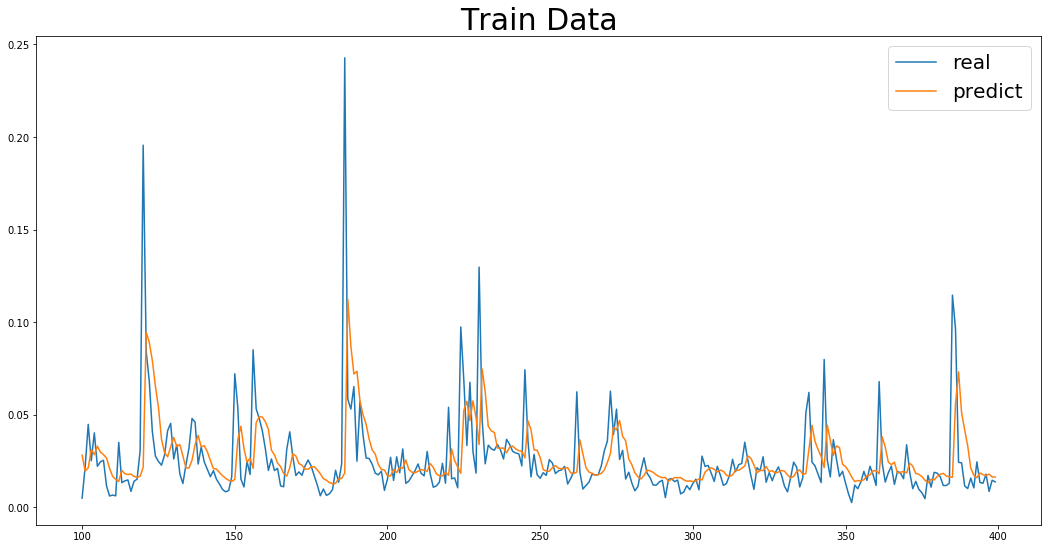

In [15]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:400,0].plot(figsize=(18,9))
draw.iloc[100:400,1].plot(figsize=(18,9))
plt.legend(('real', 'predict'),loc='upper right',fontsize='20')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [16]:
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

Text(0.5,1,'Test Data')

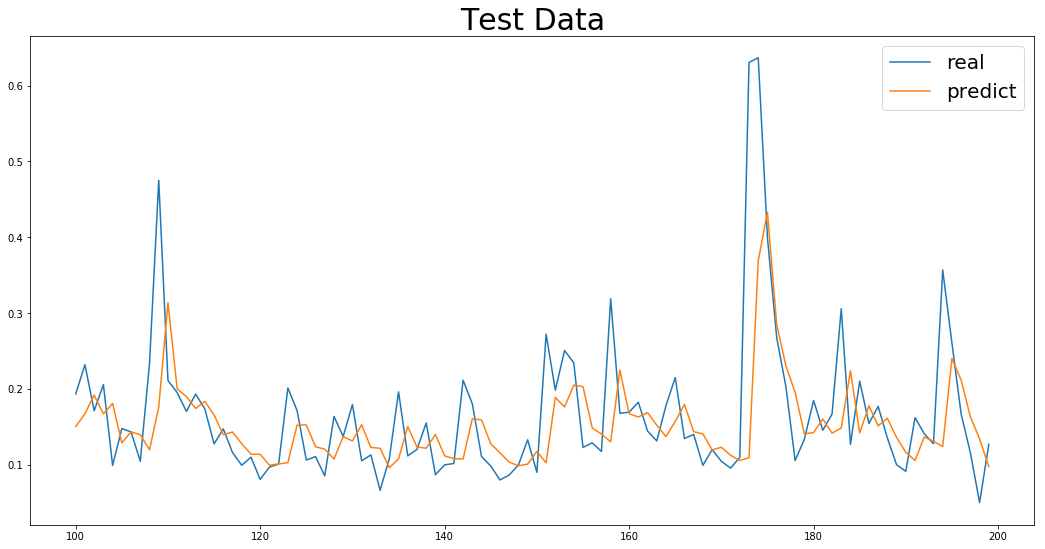

In [17]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[100:200,0].plot(figsize=(18,9))
draw.iloc[100:200,1].plot(figsize=(18,9))
plt.legend(('real', 'predict'),loc='upper right',fontsize='20')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(model.predict(X_train), y_train))
print(mean_squared_error(model.predict(X_train), y_train) )
#训练集上的MAE和MSE

0.03290657884134802
0.003579828552541158


In [19]:
print(mean_absolute_error(model.predict(X_test), y_test))
print(mean_squared_error(model.predict(X_test), y_test) )
#测试集上的MAE和MSE

0.06643398489907777
0.010958144925523631


In [56]:
predata=model.predict(X_test)[:,0]
out=predata*(rate_origin.max()-rate_origin.min())+rate_origin.min()
df0 = pd.DataFrame(out)
print('已经保存预测数据在文件predict_value.csv中')
df00=pd.concat([df2.iloc[-len(out):,0:1], df0], axis=1)
df00.to_csv('predict_volume_lstm.csv')

已经保存预测数据在文件predict_value.csv中
